In [1]:
import pandas as pd
import geopandas as gpd

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os

data_path = '/home/fterroso/data/'

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/home/fterroso/python/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [29]:
ine_trips_df = pd.read_csv(os.path.join(data_path, 'Spain-INE-covid-mob-study-mar-jun-20', 'FlujosOrigen.csv'),
                          sep='\t')
ine_trips_df = ine_trips_df.rename(columns={'FLUJO ': 'ntrips',
                                           'CELDA_ORIGEN ':'CGRUPO_o', 
                                            'NOMBRE_CELDA_ORIGEN ':'NGRUPO_o', 
                                            'CELDA_DESTINO ':'CGRUPO_d',
                                            'NOMBRE_CELDA_DESTINO ':'NGRUPO_d'})
ine_trips_df = ine_trips_df[ine_trips_df['ntrips']!='FLUJO']
ine_trips_df = ine_trips_df[ine_trips_df['DIA']!='28.CSV']
ine_trips_df['ntrips']= pd.to_numeric(ine_trips_df['ntrips'])
ine_trips_df['DIA']= ine_trips_df['DIA'].astype(str)
#ine_trips_df['DIA']= pd.to_numeric(ine_trips_df['DIA'])

/home/fterroso/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
ine_trips_df.head()

,CGRUPO_o,NGRUPO_o,CGRUPO_d,NGRUPO_d,ntrips,MES,DIA
0,21GP,Eibar,04GP,Mutriku y Mendaro,106,ABR,30
1,047M,Guadarrama,008M,Cercedilla y Navacerrada,104,ABR,30
2,164V,Alzira,013V,Corbera y otros municipios,104,ABR,30
3,097B,Parets del Vallès,016B,Vilanova del Vallès y otros municipios,104,ABR,30
4,02GI,Bescanó y otros municipios,01GI,Sant Gregori y otros municipios,104,ABR,30


In [31]:
ine_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1074640 entries, 0 to 1082385
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   CGRUPO_o  1074640 non-null  object
 1   NGRUPO_o  1074640 non-null  object
 2   CGRUPO_d  1074640 non-null  object
 3   NGRUPO_d  1074640 non-null  object
 4   ntrips    1074640 non-null  int64 
 5   MES       1074640 non-null  object
 6   DIA       1074640 non-null  object
dtypes: int64(1), object(6)
memory usage: 65.6+ MB


In [32]:
ma_gdf = gpd.read_file(os.path.join('data', 'mov_areas_enriched.geojson'), encoding="ISO-8859-1",)
ma_ids = ma_gdf['ID_GRUPO'].unique().tolist()

In [33]:
ma_gdf.head()

,ID_GRUPO,Shape_Area,CPRO,NPRO,POB_GRUPO,LITERAL_GRUPO,geometry
0,001A,8.237841e+07,3,Alicante,7.903,"Montesinos, Los y Algorfa","POLYGON ((696312.177 4215979.057, 696312.181 4..."
1,001B,1.452931e+08,8,Barcelona,14.529,Sant Joan de Vilatorrada y otros municipios,"POLYGON ((898992.611 4638407.292, 898992.603 4..."
2,001M,4.756526e+08,28,Madrid,5.149,Fuentidueña de Tajo y otros municipios,"POLYGON ((494216.778 4445259.734, 494216.385 4..."
3,001S,1.436231e+09,41,Sevilla,6.733,"Real de la Jara, El y otros municipios","POLYGON ((240629.599 4209416.214, 240629.597 4..."
4,001V,1.126422e+07,46,Valencia/Valéncia,6.277,Daimús y otros municipios,"POLYGON ((748392.315 4317155.513, 748392.289 4..."


In [34]:
month_num_dict = {'MAR':'03',
                  'ABR': '04',
                  'MAY':'05',
                  'JUN':'06'}

In [35]:
def generate_od_matrix(ids_):
    od_ = pd.DataFrame(0,columns=ids_+['total'], index=ids_+['total'])
    return od_

In [36]:
def generate_ODs_fn(trips_df, ids_, col_o, col_d):
    ods={}
    global_od_ = generate_od_matrix(ids_)
    for month in tqdm_notebook(month_num_dict.keys()):
        month_df = trips_df[trips_df['MES']==month]
        for day in tqdm_notebook(month_df['DIA'].unique(), leave=False):
            month_day_df = month_df[month_df['DIA']==day]

            date_od_matrix = generate_od_matrix(ids_)

            date_str = '2020-{}-{}'.format(month_num_dict[month], day.zfill(2))

            for origin_ma in month_day_df[col_o].unique():
                ma_trips_df = month_day_df[month_day_df[col_o]==origin_ma]
                for destination_ma in ma_trips_df[col_d].unique():
                    n_trips = ma_trips_df[ma_trips_df[col_d]==destination_ma]['ntrips'].values[0]
                    date_od_matrix.loc[origin_ma,destination_ma]= n_trips
                    global_od_.loc[origin_ma,destination_ma] += n_trips

            date_od_matrix['total'] = date_od_matrix.sum(axis=1)
            date_od_matrix.loc['total'] = date_od_matrix.sum()

            ods[date_str]= date_od_matrix
    
    global_od_['total'] = global_od_.sum(axis=1)
    global_od_.loc['total'] = global_od_.sum()
    
    return global_od_, ods

## Generate ODs at MA level

In [37]:
global_od_matrix, ods = generate_ODs_fn(ine_trips_df, ma_ids, 'CGRUPO_o', 'CGRUPO_d' )

In [38]:
#for date in tqdm_notebook(ods):
#    ods[date].to_csv(os.path.join('data', 'OD', 'date_INE_OD_{}.csv'.format(date)))

In [39]:
global_od_matrix.tail()

,001A,001B,001M,001S,001V,002A,002B,002M,002S,002V,...,40TF,57TF,58TF,43AL,44AL,45AL,53MA,79MA,80MA,total
45AL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,80201,104546,0,0,0,0,239148
53MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,109765,36900,355433
79MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,59748,0,28810,227763
80MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,16564,25721,0,130205
total,35379,67540,2579,1950,42353,80015,86516,7152,4615,42705,...,244678,149366,164547,156075,548778,361680,211784,319779,129755,292299009


In [40]:
#global_od_matrix.to_csv(os.path.join('data', 'OD', 'global_INE_OD.csv'))

## Generate OD at province level

In [41]:
trips_with_prov_df = pd.merge(ine_trips_df, ma_gdf['CPRO ID_GRUPO'.split()], left_on='CGRUPO_o', right_on='ID_GRUPO' )

In [42]:
trips_with_prov_df = pd.merge(trips_with_prov_df, ma_gdf['CPRO ID_GRUPO'.split()], left_on='CGRUPO_d', right_on='ID_GRUPO' )

In [43]:
trips_with_prov_df.head()

,CGRUPO_o,NGRUPO_o,CGRUPO_d,NGRUPO_d,ntrips,MES,DIA,CPRO_x,ID_GRUPO_x,CPRO_y,ID_GRUPO_y
0,21GP,Eibar,04GP,Mutriku y Mendaro,106,ABR,30,20,21GP,20,04GP
1,21GP,Eibar,04GP,Mutriku y Mendaro,124,ABR,28,20,21GP,20,04GP
2,21GP,Eibar,04GP,Mutriku y Mendaro,113,ABR,22,20,21GP,20,04GP
3,21GP,Eibar,04GP,Mutriku y Mendaro,107,ABR,24,20,21GP,20,04GP
4,21GP,Eibar,04GP,Mutriku y Mendaro,111,ABR,21,20,21GP,20,04GP


In [44]:
prov_ids = ma_gdf['CPRO'].unique().tolist()

In [45]:
global_od_matrix_prov, ods_prov = generate_ODs_fn(trips_with_prov_df, prov_ids, 'CPRO_x', 'CPRO_y' )

In [46]:
global_od_matrix_prov.tail()

,3,8,28,41,46,2,4,33,5,6,...,44,38,45,47,1,49,48,50,7,total
49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,110,0,20113,0,0,0,20327
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,11515,0,14974,0,0,45918
50,0,0,0,0,0,0,0,0,0,0,...,670,0,0,0,0,0,0,14029,0,31731
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14484,14484
total,73279,54864,43646,48101,58788,101856,44021,42038,30161,39919,...,18040,17488,52453,21227,69603,20357,57429,34390,14484,2094350


In [47]:
global_od_matrix_prov.to_csv(os.path.join('data', 'OD', 'global_INE_OD_prov.csv'))

Sample test

In [48]:
import datetime
date_ = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

In [49]:
date_od = ods_prov[date_.strftime('%Y-%m-%d')]

In [50]:
date_od.tail()

,3,8,28,41,46,2,4,33,5,6,...,44,38,45,47,1,49,48,50,7,total
49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,569,0,0,0,569
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,101,0,205,0,0,430
50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,223,0,382
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,207,207
total,973,869,684,519,550,1063,647,463,112,533,...,261,111,503,330,784,569,555,366,207,22241


Save ODs

In [51]:
for date in tqdm_notebook(ods_prov):
    ods_prov[date].to_csv(os.path.join('data', 'OD', 'date_INE_OD_{}_prov.csv'.format(date)))

# Plot descriptive maps

### Read MA file

In [2]:
ma_gdf = gpd.read_file(os.path.join('data', 'mov_areas_enriched.geojson'), encoding='UTF-8')
ma_gdf.shape

(3214, 7)

In [3]:
ma_nocanary_gdf = ma_gdf[(~ma_gdf['ID_GRUPO'].str.contains('GC')) & (~ma_gdf['ID_GRUPO'].str.contains('TF'))]

ma_nocanary_gdf = ma_nocanary_gdf.set_index('ID_GRUPO')

In [4]:
ma_nocanary_gdf.shape

ma_nocanary_gdf.head(3)

,Shape_Area,CPRO,NPRO,POB_GRUPO,LITERAL_GRUPO,geometry
ID_GRUPO,,,,,,
001A,8.237841e+07,3,Alicante,7.903,"Montesinos, Los y Algorfa","POLYGON ((696312.177 4215979.057, 696312.181 4..."
001B,1.452931e+08,8,Barcelona,14.529,Sant Joan de Vilatorrada y otros municipios,"POLYGON ((898992.611 4638407.292, 898992.603 4..."
001M,4.756526e+08,28,Madrid,5.149,Fuentidueña de Tajo y otros municipios,"POLYGON ((494216.778 4445259.734, 494216.385 4..."


### Read global OD matrix

In [5]:
global_od_matrix= pd.read_csv(os.path.join('data', 'OD', 'global_INE_OD.csv'), index_col=0)
global_od_matrix.tail()

,001A,001B,001M,001S,001V,002A,002B,002M,002S,002V,...,40TF,57TF,58TF,43AL,44AL,45AL,53MA,79MA,80MA,total
45AL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,80201,104546,0,0,0,0,239148
53MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,109765,36900,355433
79MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,59748,0,28810,227763
80MA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,16564,25721,0,130205
total,35379,67540,2579,1950,42353,80015,86516,7152,4615,42705,...,244678,149366,164547,156075,548778,361680,211784,319779,129755,292299009


## Total outgoing trips map

In [6]:
ma_nocanary_gdf['outgoing_trips'] = global_od_matrix['total']

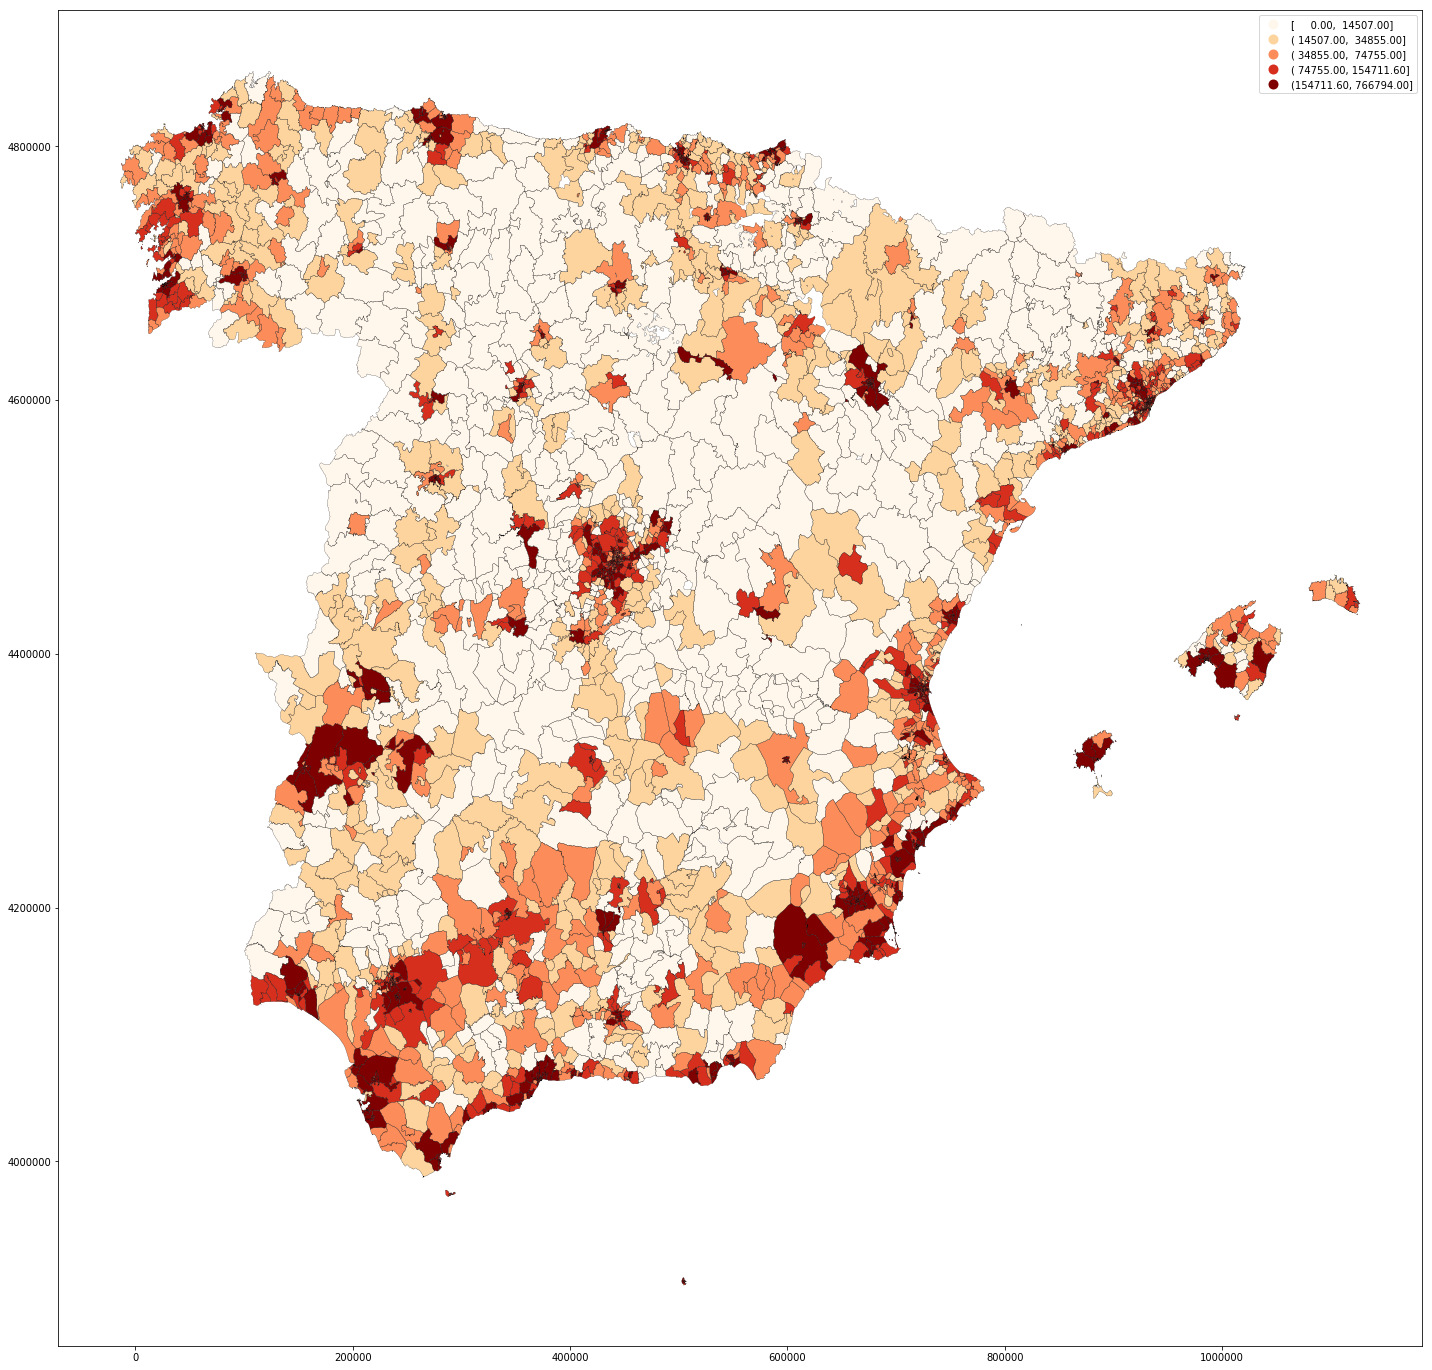

In [7]:
ax= ma_nocanary_gdf.plot(column='outgoing_trips', legend=True, figsize=(20,30),cmap='OrRd', scheme='quantiles');
ma_nocanary_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.2,ax=ax); 
#ax.legend(loc='lower right')
#plt.title('Total number of outgoing trips');
plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_outgoing_map.png'))

## Total incoming trips map

In [8]:
incoming_trips_df = global_od_matrix.loc['total'].to_frame()

incoming_trips_df.head()

,total
001A,35379
001B,67540
001M,2579
001S,1950
001V,42353


In [9]:
ma_nocanary_gdf['incoming_trips'] = incoming_trips_df['total']

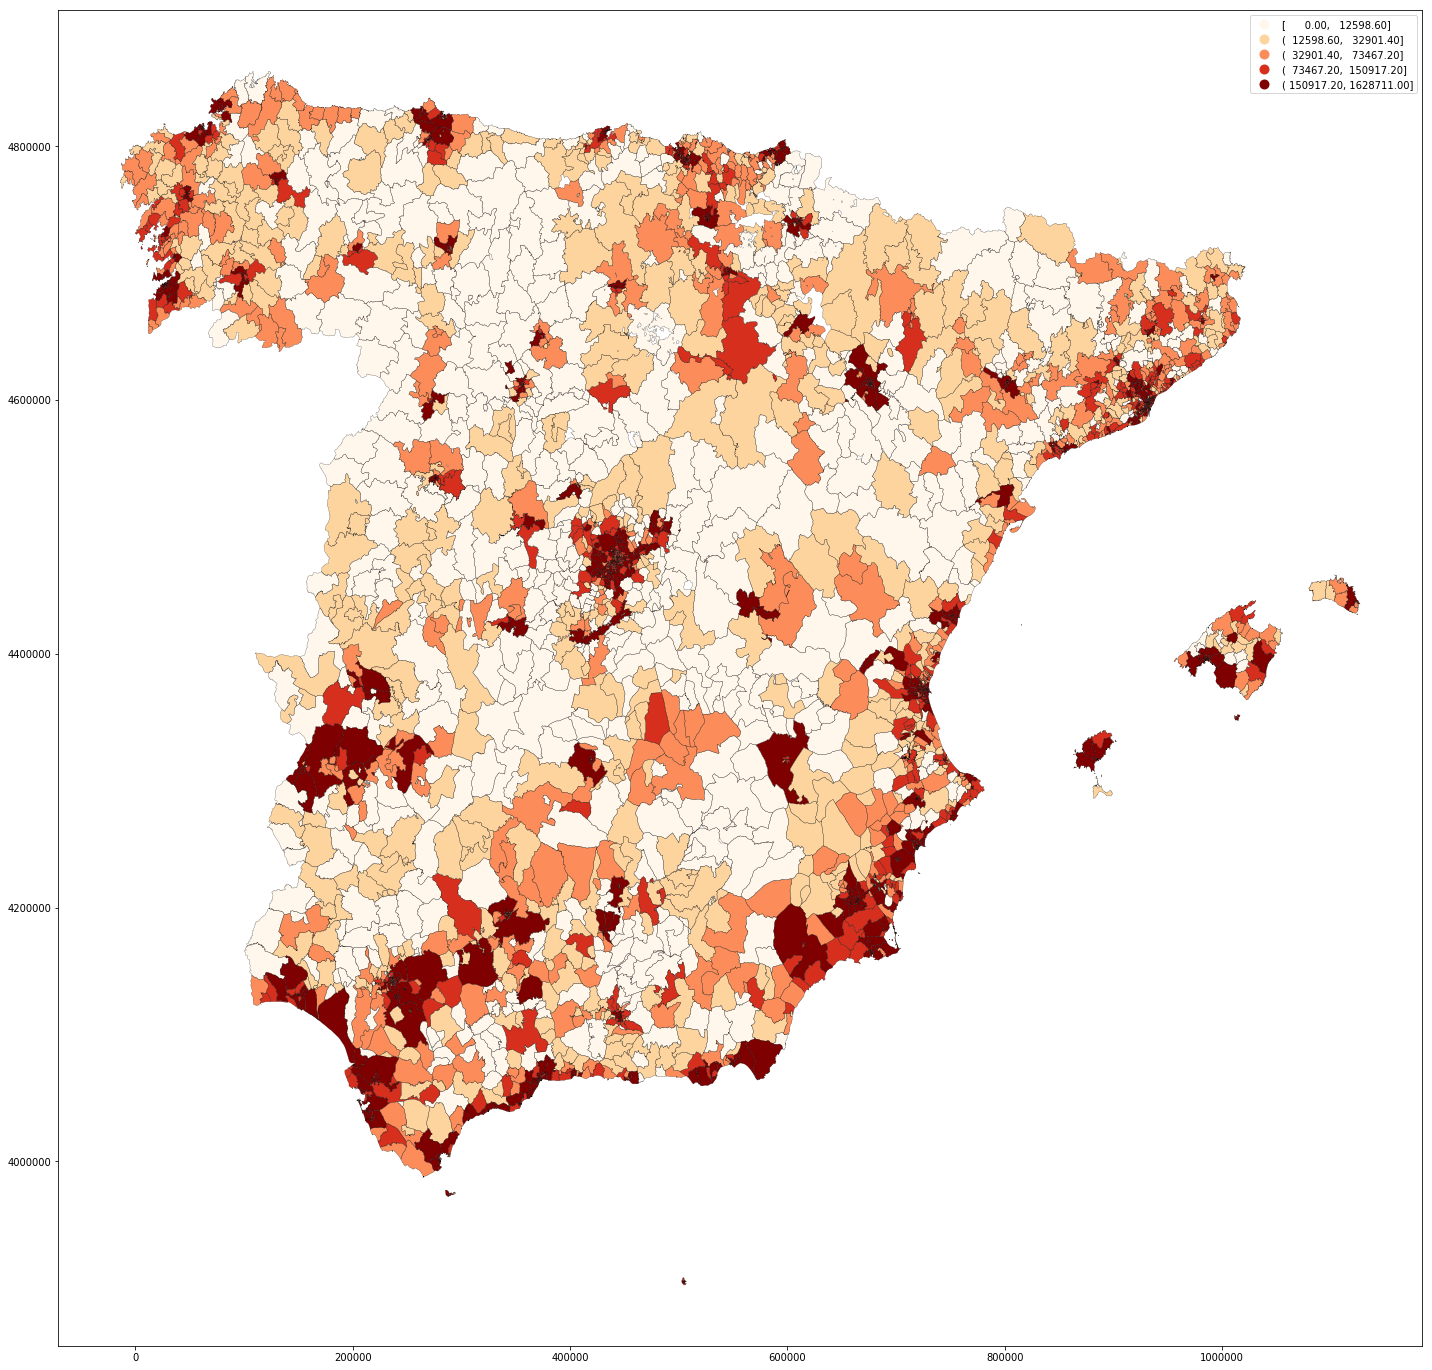

In [10]:
ax= ma_nocanary_gdf.plot(column='incoming_trips', legend=True, figsize=(20,30),cmap='OrRd', scheme='quantiles');
ma_nocanary_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.2,ax=ax); 
#plt.title('Total number of incoming trips');
plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_incoming_map.png'))

## Difference through time period

In [3]:
from scipy.stats import linregress

In [4]:
def calculate_slope_fn(row):
    x= row.index.tolist()
    y= row.values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

In [5]:
import datetime
from datetime import date, timedelta

def generate_trips_diff_fn():
    i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')
    test_od= pd.read_csv(os.path.join('data', 'OD', 'date_INE_OD_{}.csv'.format(i_date.strftime('%Y-%m-%d'))), 
                        index_col=0)
    ids= test_od.columns.tolist()
    
    e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d') #datetime.datetime.now()
    i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

    delta = e_date - i_date       # as timedelta
    
    df_ = pd.DataFrame(0,index=ids, columns=range(1,delta.days+1))
    
    target_days = []
    for i in range(delta.days):
        next_day = i_date + timedelta(days=i)

        next_od= pd.read_csv(os.path.join('data', 'OD', 'date_INE_OD_{}.csv'.format(next_day.strftime('%Y-%m-%d'))), 
                            index_col=0)

        df_[i] = next_od['total']
    df_['slope']= df_.apply(lambda row:calculate_slope_fn(row), axis=1)
    df_['slope_rank']=df_['slope'].rank(ascending=False, method='first')
    return df_

In [16]:
total_diff_df= generate_trips_diff_fn()

In [17]:
total_diff_no_total_df= total_diff_df.drop('total')

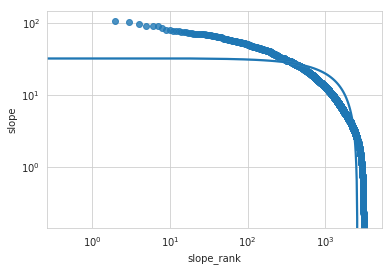

In [18]:
sns.set_style("whitegrid")
ax= sns.regplot(x=total_diff_no_total_df['slope_rank'], y=total_diff_no_total_df['slope'])
ax.set_xscale('log')
ax.set_yscale('log')

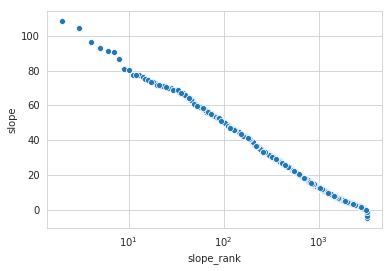

In [19]:
sns.set_style("whitegrid")
ax= sns.scatterplot(data=total_diff_no_total_df, x='slope_rank', y='slope')
ax.set_xscale('log')

### Now we compare with the TWT datasets

In [20]:
total_diff_twt_df= pd.read_csv(os.path.join('data', 'diff_trips_TWT.csv'), index_col=0)

In [21]:
total_diff_twt_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,74,75,76,77,78,79,80,0,slope,slope_rank
44AL,6,2,0,3,5,5,0,2,4,5,...,2,0,2,2,6,6,0,0,0.002371,1509.0
45AL,0,2,0,0,1,8,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.008401,3093.0
53MA,0,0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.001513,1672.0
79MA,5,4,0,6,8,0,0,2,6,0,...,11,9,2,10,11,7,0,2,0.086766,49.0
80MA,2,4,3,4,0,0,0,0,0,3,...,2,0,1,4,1,2,0,0,0.006346,943.0


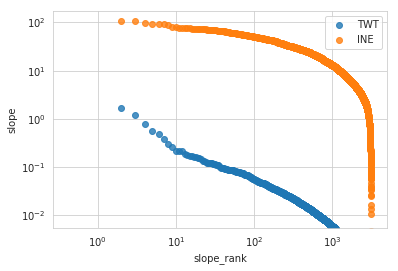

In [36]:
sns.set_style("whitegrid")
ax=sns.regplot(x=total_diff_twt_df['slope_rank'], y=total_diff_twt_df['slope'],fit_reg=False, label='TWT')
sns.regplot(ax=ax,x=total_diff_no_total_df['slope_rank'], y=total_diff_no_total_df['slope'],fit_reg=False,label='INE')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

### Plot the map

In [ ]:
ma_nocanary_gdf['diff_trips'] = total_diff_df['slope']

In [ ]:
total_diff_df['slope']= total_diff_df.apply(lambda row:calculate_slope_fn(row), axis=1)

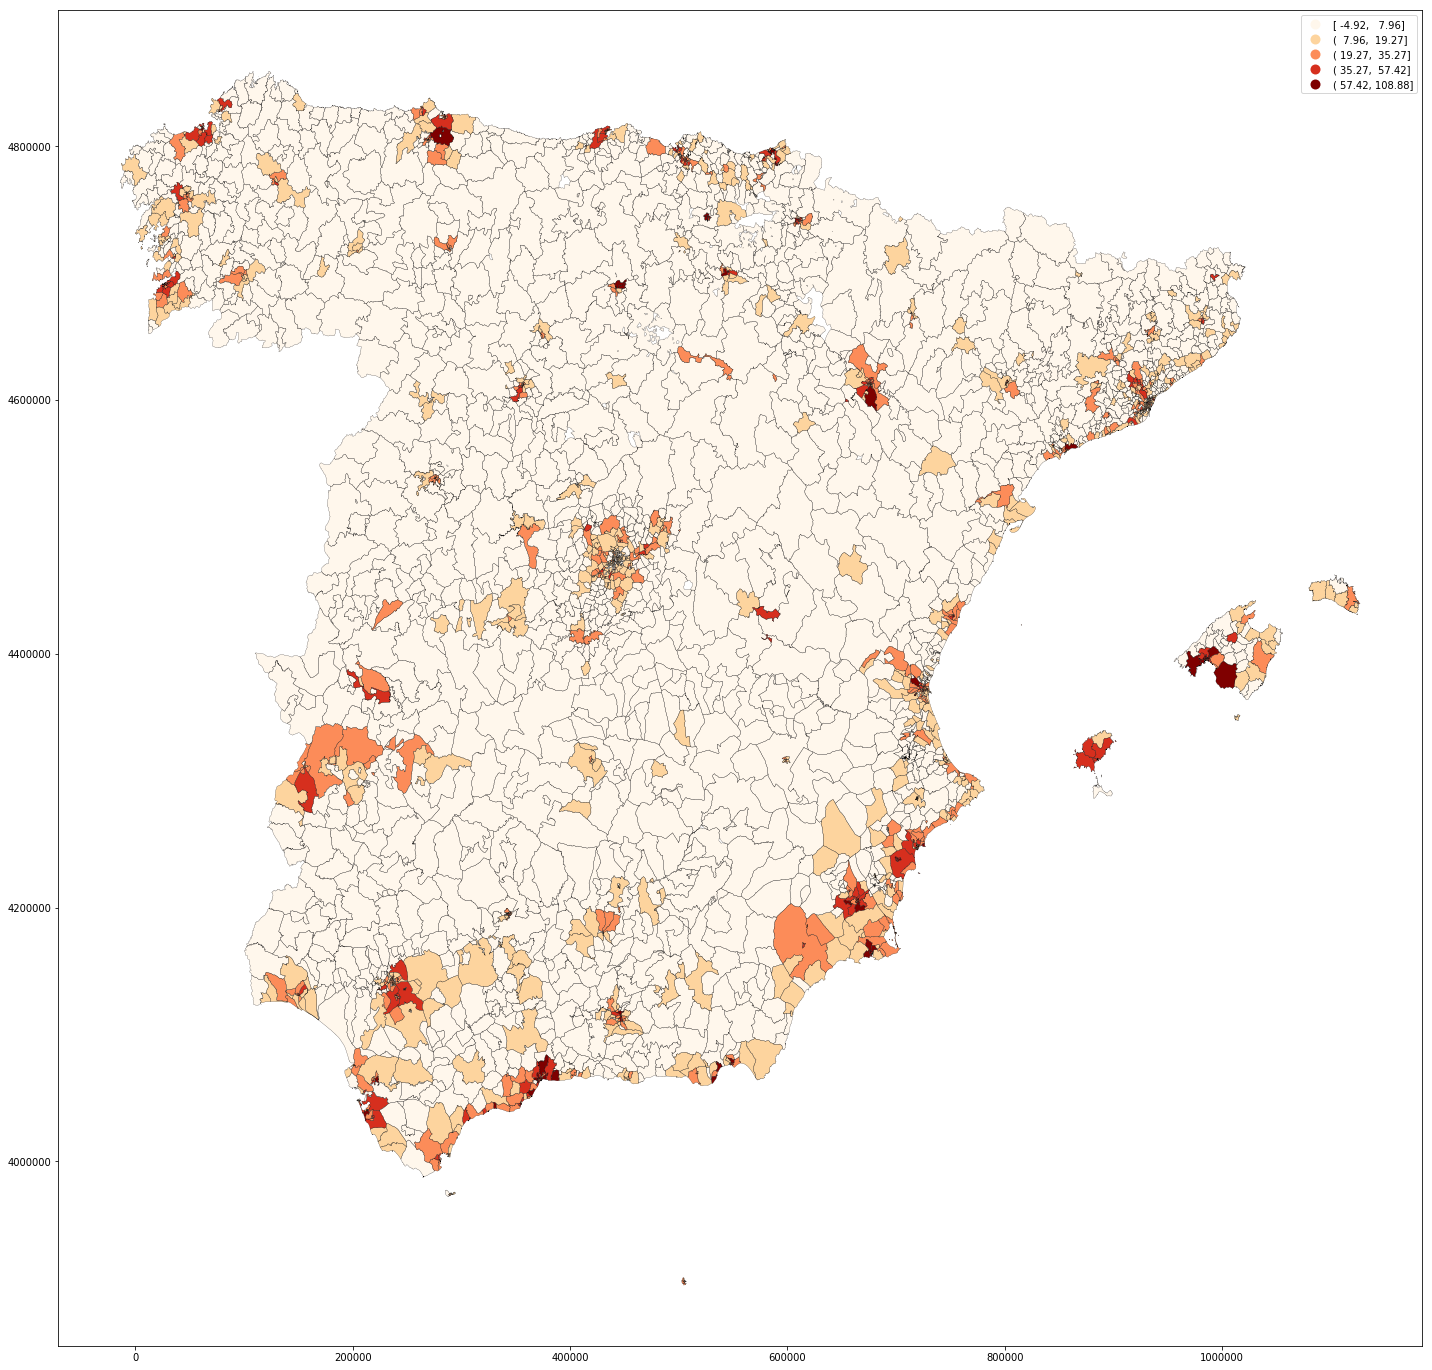

In [16]:
ax= ma_nocanary_gdf.plot(column='diff_trips', legend=True, figsize=(20,30),cmap='OrRd', scheme='FisherJenks');
ma_nocanary_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.2,ax=ax); 
#plt.title('Difference in trips');
plt.tight_layout()
plt.savefig(os.path.join('figs', 'ine_diff_map.png'))

In [ ]:
print("That's all folks!!")